In [1]:
"""
Created by Flavio Martinelli at 13:09 18/05/2020
"""
import colorama
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import maze_plot as mplot
import tensorflow as tf
import tensorflow_probability as tfp
import tf_agents.networks.network as tf_network

from tqdm.notebook import trange, tqdm
from tf_agents.environments import utils
from tf_agents.environments import tf_py_environment
from tf_agents.policies import actor_policy
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.specs import array_spec

from maze_tf import Maze2D

### Create environment

State: 	 12
Reward position: 0


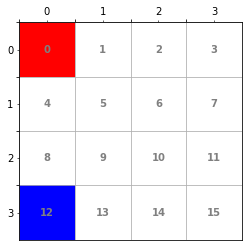

In [2]:
size=(4,4)

environment = Maze2D(size, walls=True, gamma=0.9, proba_opposite=0.0333, proba_others=0.0333)
environment = tf_py_environment.TFPyEnvironment(environment)

# Reset environment and creates first initial_time_step of trajectory
initial_time_step = environment.reset()
print(f"State: \t {initial_time_step.observation[0,0].numpy()}")
print(f"Reward position: {environment.pyenv.envs[0].reward_pos}")

fig, ax = mplot.base_fig(size)
mplot.draw_cell_numbers(ax, environment.pyenv.envs[0].maze_array)
mplot.color_square(ax, environment.pyenv.envs[0].get_coordinates(environment.pyenv.envs[0]._state), 'b')
mplot.color_square(ax, environment.pyenv.envs[0].get_coordinates(environment.pyenv.envs[0].reward_pos), 'r')

### Useful specs

In [3]:
action_shape = environment.action_spec().maximum + 1
value_shape = 1
print(action_shape)
print(value_shape)

time_step_spec = ts.time_step_spec(environment.observation_spec())
action_spec = environment.action_spec()
max_one_hot = np.prod(size)
print(time_step_spec)
print(action_spec)
print(max_one_hot)

4
1
TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(1,), dtype=tf.int32, name='observation', minimum=array(0), maximum=array(15)))
BoundedTensorSpec(shape=(1,), dtype=tf.int32, name='action', minimum=array(0), maximum=array(3))
16


### Linear Readout Network

In [4]:
class ActorLinearReadout(tf_network.Network):

    def __init__(self, max_one_hot, output_shape):
        self.max_one_hot = max_one_hot
        input_state_spec = tf.TensorSpec(shape=(self.max_one_hot), dtype=np.int32, name='one_hot_obs')

        super(ActorLinearReadout, self).__init__(
            input_tensor_spec=input_state_spec,
            state_spec=(),
            name='LinearReadout')
        
        self._sub_layers = [tf.keras.layers.Dense(output_shape,
                                                  activation=None, kernel_initializer='zero',
                                                  use_bias=False)]

    def call(self, observations, step_type, network_state):
        del step_type
        
        # Transform int32 state into one_hot encoded tensor
        output = tf.one_hot(indices=observations, depth=self.max_one_hot, dtype=tf.float32, axis=-1)
        
        for layer in self._sub_layers:
            output = layer(output)
        output = tf.nn.softmax(output)
        
        actions_categorical_dist = tfp.distributions.Categorical(probs=output, dtype=tf.int32)
        
        # Scale and shift actions to the correct range if necessary.
        return actions_categorical_dist, network_state
    
class CriticLinearReadout(tf_network.Network):

    def __init__(self, max_one_hot, output_shape):
        self.max_one_hot = max_one_hot
        input_state_spec = tf.TensorSpec(shape=(self.max_one_hot), dtype=np.int32, name='one_hot_obs')

        super(CriticLinearReadout, self).__init__(
            input_tensor_spec=input_state_spec,
            state_spec=(),
            name='LinearReadout')
        
        self._sub_layers = [tf.keras.layers.Dense(output_shape,
                                                  activation=None, kernel_initializer='zero',
                                                  use_bias=False)]

    def call(self, observations, step_type, network_state):
        del step_type
        
        # Transform int32 state into one_hot encoded tensor
        output = tf.one_hot(indices=observations, depth=self.max_one_hot, dtype=tf.float32, axis=-1)

        for layer in self._sub_layers:
            output = layer(output)
                
        # Scale and shift actions to the correct range if necessary.
        return tf.squeeze(output, axis=-1), network_state

### Define networks and policies

In [5]:
actor_net = ActorLinearReadout(max_one_hot, action_shape)
value_net = CriticLinearReadout(max_one_hot, value_shape)

actor = actor_policy.ActorPolicy(time_step_spec=time_step_spec, action_spec=action_spec, actor_network=actor_net)

value_net.create_variables()

### Define training loop parameters

In [6]:
episode_lenght = tf.constant(50)
gamma = 0.9
batch_size = 1
lr = 0.02
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

### Define episode collection driver

The driver will load actions and observations to the corresponding lists, reinitialize them every new episode.

When calling driver.run remember to specify the initial_time_step which should correspond to the initial state of each maze.

In [7]:
# Pre compute triangular matrix of gamma powers, useful to compute future return
increasing_t_steps = tf.range(episode_lenght, dtype=tf.float32)
returns = (tf.ones(episode_lenght)*gamma)**increasing_t_steps
rolling=[]
for r in range(episode_lenght):
    rolling.append(tf.roll(returns, r, axis=0))
gamma_matrix = tf.linalg.band_part(tf.stack(rolling, axis=0), 0, -1)

observations = []
actions = []
rewards = []
collect_obs = lambda rb: observations.append(rb.observation)
collect_act = lambda rb: actions.append(rb.action)
collect_rew = lambda rb: rewards.append(rb.reward)
env_steps = tf_metrics.EnvironmentSteps()

observers = [collect_obs, collect_act, collect_rew, env_steps]
# driver = dynamic_episode_driver.DynamicEpisodeDriver(environment, actor, observers, num_episodes=1)
driver = dynamic_step_driver.DynamicStepDriver(environment, actor, observers, num_steps=episode_lenght)

### Train

In [8]:
@tf.function(experimental_relax_shapes=False)
def loss_fun(value_net, actor_net, observations, actions, rewards, returns, gamma_matrix, optimizer):
    
    # to substitute with proper batching
    returns = tf.expand_dims(tf.linalg.matvec(gamma_matrix, rewards), 0)
    
    # Compute losses
    with tf.GradientTape() as tape:

        # critic loss
        v_estimates, _ = value_net(observations, (), ())
        critic_loss = tf.reduce_sum((v_estimates - returns)**2)

        # actor loss
        d, _ = actor_net(observations, (), ())
        gather_indices = tf.stack([tf.range(tot_time_steps, dtype=tf.int32), actions], axis=1)

        log_pi = tf.math.log(tf.gather_nd(tf.squeeze(d.probs, axis=0), gather_indices))

        actor_loss = tf.reduce_sum(log_pi*tf.stop_gradient(value_net(observations, (), ())[0] - returns))

        loss = critic_loss + actor_loss

        grads = tape.gradient(loss, actor_net.trainable_weights + value_net.trainable_weights)
        optimizer.apply_gradients(zip(grads, actor_net.trainable_weights + value_net.trainable_weights))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Text(0.5, 1.0, 'Cumulative reward per episode')

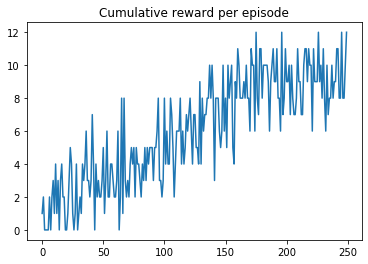

In [9]:
trace = []
tot_episodes = 250

with trange(tot_episodes, desc='inner loop', position=1, leave=False) as t:
    for e in t:
        # Collect episode
        observations = []
        actions = []
        rewards = []
        env_steps.reset()
        
        initial_time_step, _ = driver.run(time_step=initial_time_step)
                
        observations = tf.stack(observations[:episode_lenght], axis=1)[:,:,0]
        actions = tf.squeeze(tf.stack(actions[:episode_lenght], axis=1))
        rewards = tf.squeeze(tf.stack(rewards[:episode_lenght], axis=1))
                
        tot_time_steps = env_steps.result()
        
        loss_fun(value_net, actor_net, observations, actions, rewards, returns, gamma_matrix, optimizer)
       
        trace.append(tf.reduce_sum(rewards).numpy())
        t.set_postfix(tot_reward=tf.reduce_sum(rewards).numpy())                        

plt.plot(trace)
plt.title("Cumulative reward per episode")

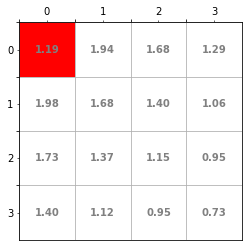

In [10]:
v_vals = np.array([f"{v[0]:.2f}"for v in value_net.trainable_weights[0].numpy()]).reshape(4,4)
fig, ax = mplot.base_fig(size)
mplot.draw_cell_numbers(ax, v_vals)
mplot.color_square(ax, environment.pyenv.envs[0].get_coordinates(environment.pyenv.envs[0].reward_pos), 'r')

In [11]:
actions

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([3, 2, 1, 1, 3, 1, 1, 1, 2, 3, 2, 1, 3, 3, 3, 3, 2, 0, 1, 3, 1, 3,
       3, 3, 2, 2, 3, 3, 3, 2, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3,
       1, 1, 1, 3, 2, 0])>